# Open exploration for the Lake Model

## 01. The lake model - explanation
The exploratory modeling workbench includes an example folder. This folder contains a variety of examples that demonstrate the functionality of the workbench. Many of these examples have been drawn from published cases. Here, we use the Lake Problem as an example for demonstrating some of the key functionality of the workbench. 

We demonstrate some of the key capabilities of the exploratory modeling workbench using the Lake problem. The lake problem is a stylized and hypothetical decision problem where the population of a city has to decide on the amount of annual pollution it will put into a lake. It the pollution in the lake passes a threshold, it will suffer irreversible eutrophication. 

\begin{equation}
    X_{(t+1)}=X_t+a_t+\frac{(X_t^q)}{(1+X_t^q )}- bX_t+\epsilon_t
\end{equation}

where $X_t$ is the pollution at time $t$, $a_t$ is the rate of anthropogenic pollution at time $t$, $b$ is the lake’s natural removal rate, $q$ is the lake's natural recycling rate, $\epsilon_t$ is the rate of natural pollution at time $t$. The rate of anthropogenic pollution $a_t$ is the decision variable and is somewhere between 0, and 0.1. So $a_t \in [0,0.1]$. The natural pollution $\epsilon_t$ is modeled, following Singh et al. (2015), as a log normal distribution with mean $\mu$ and standard deviation $\sigma$. 
There are four outcomes of interest. The first is the average concentration of phosphor in the lake. 

\begin{equation}
    f_{phosphorus}=  \frac{1}{\left\vert{T}\right\vert} \sum\limits_{t\in{T}} X_t 
\end{equation}

where $\left\vert{T}\right\vert$ is the cardinality of the set of points in time. 
The second objective is the economic benefit derived from polluting the lake. Following Singh et al. (2015), this is defined as the discounted benefit of pollution mines the costs of having a polluted lake

\begin{equation}
    f_{economic} = \sum\limits_{t \in {T}}\alpha a_t \delta^t 
\end{equation}

where $\alpha$ is the utility derived from polluting and $\delta$ is the discount rate. By default, $\alpha$ is 0.04.
The third objective is related to the year over year change in the anthropogenic pollution rate. 

\begin{equation}
    f_{inertia} =\frac{1}{\left\vert{T}\right\vert-1} \sum\limits_{t=1}^{\left\vert{T}\right\vert} I(|a_{t}-a_{t-1} |>\tau)   
\end{equation}

where $I$ is an indicator function that is 0 if the statement is false, and 1 if the statement is true, $\tau$ is the threshold that is deemed undesirable, and is for illustrative purposes et to 0.2. Effectively, f_{inertia} is the fraction of years where the absolute value of the change in anthropogenic pollution is larger then $\tau$.
The fourth objective is the fraction of years where the pollution in the lake is below the critical threshold.

\begin{equation}
    f_{reliability} =  \frac{1}{\left\vert{T}\right\vert} \sum\limits_{t \in T}I(X_{t}<X_{crit} ) 
\end{equation}

where $I$ is an indicator function that is 0 if the statement is false, and 1 if the statement is true, $X_{crit}$ is the critical threshold of pollution and is a function of both $b$ and $q$.

The lake problem is characterized by both stochastic uncertainty and deep uncertainty. The stochastic uncertainty arises from the natural inflow. To reduce this stochastic uncertainty, multiple replications are performed and the average over the replication is taken. Deep uncertainty is presented by uncertainty about the mean $\mu$ and standard deviation $sigma$ of the lognormal distribution characterizing the natural inflow, the natural removal rate of the lake $\beta$, the natural recycling rate of the lake $q$, and the discount rate $\delta$. The table below specifies the ranges for the deeply uncertain factors, as well as their best estimate or default values. 


## 02. The lake model - Uncertainties
For the uncertainties, use the following table

|Parameter	|Range	        |Default value|
|-----------|--------------:|------------:|
|Mean natural pollution $\mu$    	|0.01 – 0.05	|0.02         |
|Std dev natural pollution $\sigma$	|0.001 – 0.005 	|0.0017       |
|Lake's natural removal rate $b$      	|0.1 – 0.45	    |0.42         |
|Lake's natural recycling rate $q$	    |2 – 4.5	    |2            |
|Discount rate $\delta$	|0.93 – 0.99	|0.98         |

For now, we assume that for each year a release decision is made. The release is between 0 and 0.1.

## 03. Connecting the model and specifying the XLRM

First, we import the relevant functions and classes from the ema_workbench package, and the lake model from an external py file

In [1]:
#These classes are for defining the model instances based on the XLRM framework
from ema_workbench import (Model, RealParameter, ScalarOutcome)

#The lake model is provided in lakemodel_function.py in this repository
from lakemodel_function import lake_problem

In [2]:
#Other default python libraries for data handling, manipulation, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Next, we define the problem using the XLRM framework

In [3]:
#The 'R' - instantiate the model - the 'R'
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#The 'X' - specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

#The 'L' - set levers, one for each time step
lake_model.levers = [RealParameter(str(i), 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#The 'M' - specify outcomes or performance metrics
lake_model.outcomes = [ScalarOutcome('max_P'),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]

## 04. Running 1000 scenarios - no policy

Similar to before, we first import relevant functions and classes from the ema_workbench library

In [4]:
# Policy is for defining a policy object
# perform_experiments is for running an experiment by using a model instance
from ema_workbench import Policy, perform_experiments

# ema_logging is for seeing the progress of the experiments
# SequentialEvaluator is for running the experiments using only a single process
# MultiprocessingEvaluator is for running the experiments using multiple processes
from ema_workbench import ema_logging, SequentialEvaluator, MultiprocessingEvaluator

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

Now we run the experiments

In [5]:
# First, we apply a no release policy (nothing is being released to the lake in all time steps)
policy = Policy("no release", **{l.name:0 for l in lake_model.levers})

# Second, we specify the number of scenarios
n_scenarios = 1000

# Third, we ask the workbench to run the experiments
with MultiprocessingEvaluator(lake_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policy)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Let's observe the results.

The 'X' and 'L' can be observed from the experiments variable, whereas the 'M' can be observed from the outcomes variable

In [6]:
# Here we unpack the results into experiments and outcomes
experiments, outcomes = results
outcomes_df = pd.DataFrame(outcomes)

In [7]:
# Let's observe the input parameters of the first five scenarios
experiments.head(5)

,b,delta,mean,q,stdev,0,1,2,3,4,...,93,94,95,96,97,98,99,scenario,policy,model
0,0.122744,0.948389,0.018980,2.250495,0.002177,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,no release,lakeproblem
1,0.232141,0.969955,0.023915,2.794098,0.003786,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,no release,lakeproblem
2,0.283644,0.971816,0.043776,3.310144,0.002770,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,no release,lakeproblem
3,0.144688,0.951836,0.018071,4.162324,0.003169,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,no release,lakeproblem
4,0.149561,0.985933,0.012316,4.278481,0.003658,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,no release,lakeproblem


In [8]:
# Let's observe the outcomes of the first five scenarios
outcomes_df.head(5)

,max_P,utility,inertia,reliability
0,8.231888,0.0,0.0,0.1381
1,0.114318,0.0,0.0,1.0000
2,0.163885,0.0,0.0,1.0000
3,0.127373,0.0,0.0,1.0000
4,0.083804,0.0,0.0,1.0000


We can use the seaborn (sns) library for observing the results

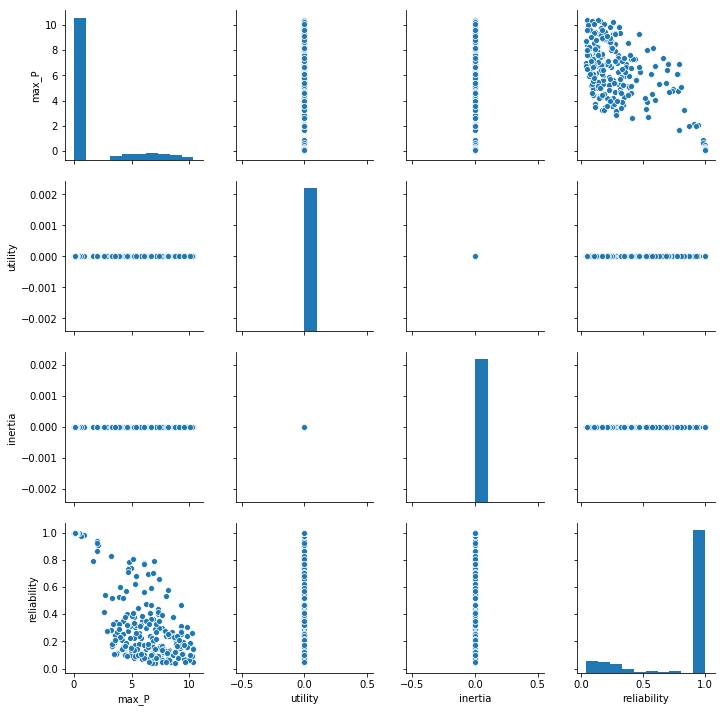

In [9]:
sns.pairplot(outcomes_df)
plt.show()

## 05. Running 1000 scenarios + 10 random policies

So far we assign the value 0 for annual anthropogenic pollution in all time steps. We can also ask the workbench to generate 4 random policies

In [10]:
n_scenarios = 1000 #number of scenarios -> in this case 1000 random combination values for each 'X' variables
n_policies = 4 #number of policies -> in this case 4 random combinations of values for each 'L'

# EMA workbench will generate an exhaustive policy design where each policy is tested in each scenario
# In our case, this results in 4000 experiments
with MultiprocessingEvaluator(lake_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, n_policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 4 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [11]:
experiments, outcomes = results
outcomes_df = pd.DataFrame(outcomes)

In [12]:
experiments.head(5)

,b,delta,mean,q,stdev,0,1,10,11,12,...,93,94,95,96,97,98,99,scenario,policy,model
0,0.257950,0.932534,0.016506,2.479357,0.002582,0.080023,0.086616,0.039379,0.024375,0.021573,...,0.027318,0.051654,0.071557,0.042665,0.012966,0.058164,0.035618,1000,0,lakeproblem
1,0.427875,0.967838,0.036324,2.057055,0.003220,0.080023,0.086616,0.039379,0.024375,0.021573,...,0.027318,0.051654,0.071557,0.042665,0.012966,0.058164,0.035618,1001,0,lakeproblem
2,0.199981,0.975906,0.031283,2.339414,0.002803,0.080023,0.086616,0.039379,0.024375,0.021573,...,0.027318,0.051654,0.071557,0.042665,0.012966,0.058164,0.035618,1002,0,lakeproblem
3,0.428512,0.977695,0.048053,2.919389,0.002874,0.080023,0.086616,0.039379,0.024375,0.021573,...,0.027318,0.051654,0.071557,0.042665,0.012966,0.058164,0.035618,1003,0,lakeproblem
4,0.179982,0.955520,0.037671,3.608735,0.003636,0.080023,0.086616,0.039379,0.024375,0.021573,...,0.027318,0.051654,0.071557,0.042665,0.012966,0.058164,0.035618,1004,0,lakeproblem


In [13]:
outcomes_df.head(5)

,max_P,utility,inertia,reliability
0,4.080456,0.287861,0.59596,0.1488
1,2.197982,0.587335,0.59596,0.1721
2,5.380458,0.745384,0.59596,0.0346
3,0.440168,0.789957,0.59596,1.0000
4,6.109178,0.435117,0.59596,0.1139


Using seaborn, we can compare the results of each policy 

C:\Users\bjafino\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\bjafino\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


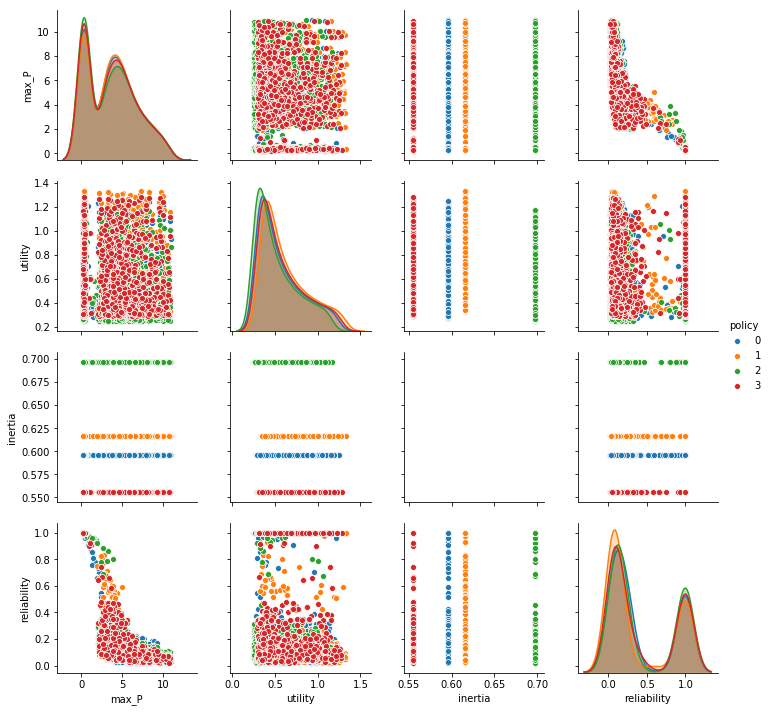

In [14]:
policies = experiments['policy']
outcomes_df['policy'] = policies

sns.pairplot(outcomes_df, hue='policy',  vars=outcomes.keys())
plt.show()

We can also observe each performance indicator independently

In [15]:
outcomes_df.columns

Index(['max_P', 'utility', 'inertia', 'reliability', 'policy'], dtype='object')

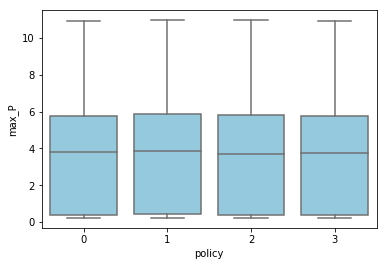

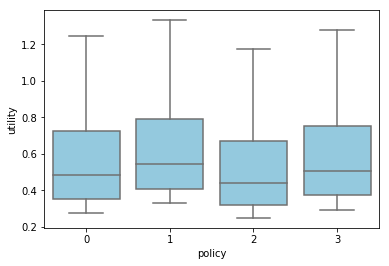

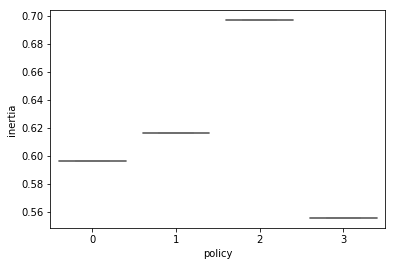

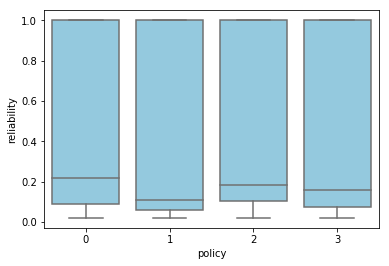

In [16]:
for var in outcomes_df.columns[:-1]:
    sns.boxplot(x='policy', y=var, data=outcomes_df, color='skyblue')
    plt.show()

## 06. Scenario discovery
In scenario discovery, we want to find a region in the input space that best explains our outcomes of interest. The first step is therefore to define what our outcomes of interest are. Let's say that we want to find conditions that lead to relatively low utility, that is, the 10% worse reliability.

First we need to clean the experiments dataframe so that it only contains the uncertain variables.

In [17]:
experiments.columns

Index(['b', 'delta', 'mean', 'q', 'stdev', '0', '1', '10', '11', '12',
       ...
       '93', '94', '95', '96', '97', '98', '99', 'scenario', 'policy',
       'model'],
      dtype='object', length=108)

From the print above we see that the uncertain variables are the first 5 columns of the dataframe, whereas the 'policy' variable is located at the end of the list. So we simply take these first five columns and append the 'policy' variable manually.

In [18]:
cleaned_experiments = experiments[list(experiments.columns[:5]) + ['policy']]

Next we define our ooi (outcomes of interest).

In [19]:
data = outcomes['reliability']
ooi = data < np.percentile(data, 10)

# You can also specify strict threshold, such as:
# ooi = outcomes['utility'] < 0.4

#Let's see how many scenarios belong to our outcomes of interest
print('There are {} scenarios within outcomes of interest. This number corresponds to {}% of the total scenarios'.\
      format(ooi.sum(), ooi.sum() / len(ooi) * 100))

There are 346 scenarios within outcomes of interest. This number corresponds to 8.649999999999999% of the total scenarios


Now we run the PRIM algorithm for scenario discovery

In [20]:
from ema_workbench.analysis import prim

prim_alg = prim.Prim(cleaned_experiments, ooi, threshold=0.8)
box1 = prim_alg.find_box()

C:\Users\bjafino\anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\bjafino\anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\bjafino\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
[MainProcess/INFO] 4000 points remaining, containing 346 cases of interest
[MainProcess/INFO] mean: 0.8125, mass: 0.072, coverage: 0.6763005780346821, density: 0.8125 restricted_dimensions: 4


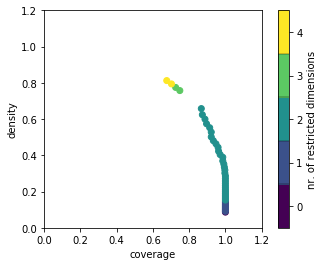

In [21]:
box1.show_tradeoff()
plt.show()

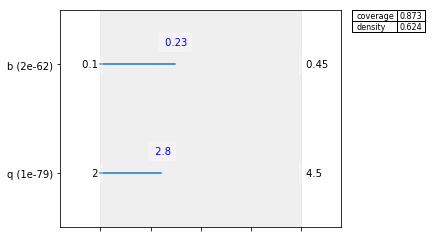

In [22]:
box1.inspect(40, style='graph')
plt.show()

## 07. Sensitivity analysis

Here, we try to identify input factors that best explain the variance in the performance metrics. Put differently, we try to identify the critical drivers of each performance metrics.

We use the Extra Tree algorithm to identify the most critical drivers of each performance metric.

In [23]:
from ema_workbench.analysis import feature_scoring

In [24]:
scores = feature_scoring.get_feature_scores_all(cleaned_experiments, outcomes)

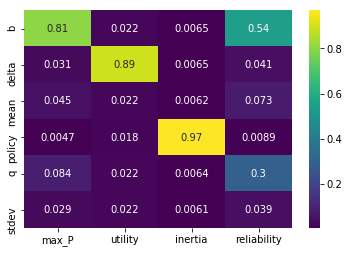

In [25]:
sns.heatmap(scores, cmap='viridis', annot=True)
plt.show()

The workbench also has the Sobol sensitivity analysis functionality, which is the most widely used global sensitivity analysis technique (https://doi.org/10.1016/j.envsoft.2019.01.012). Nonetheless, recent study has shown that the Extra Tree algorithm can approximate Sobol's total indices with satisfactory accuracy and substantially lower computational cost (https://doi.org/10.1016/j.envsoft.2018.06.011).

Note that the Sobol analysis will require N(2k+2) samples, where N is a baseline number of experiments required to cover the uncertainties (let's also assume 1000 in this case) and k is the number of uncertainties. We have k = 4 uncertainties, so we'll have 1000 * (8 + 2) = 10,000 experiments in total. We can choose the sampling by specifying the uncertainty_sampling argument; note that the Sobol sampler automatically adjusts the number of experiments based on the number of uncertainties and the specified value of N.

In [26]:
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

problem = get_SALib_problem(lake_model.uncertainties)
print(problem)

{'num_vars': 5, 'names': ['b', 'delta', 'mean', 'q', 'stdev'], 'bounds': [(0.1, 0.45), (0.93, 0.99), (0.01, 0.05), (2.0, 4.5), (0.001, 0.005)]}


Now we are going to test Sobol analysis using a no policy setting.

In [27]:
# First, we apply a random release policy (nothing is being released to the lake in all time steps)
policy = Policy("no release", **{l.name:np.random.rand(1)[0]/10 for l in lake_model.levers})

# Second, we specify the number of scenarios
n_scenarios = 500

# Third, we ask the workbench to run the experiments
with MultiprocessingEvaluator(lake_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policy, uncertainty_sampling='sobol')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 6000 scenarios * 1 policies * 1 model(s) = 6000 experiments
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4200 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 5400 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [28]:
experiments, outcomes = results

#let's extract each outcome variable independently
max_P = outcomes['max_P']
utility = outcomes['utility']
inertia = outcomes['inertia']
reliability = outcomes['reliability']

Sobol analysis dissects the sensitivity score of each variable into first-order, higher-order, and total order sensitivity indices. Higher-order sensitivity indices (second-order, third-order, etc) represent the interaction effects of that variable with all other variables. For simplicity, one normally looks only at the total order sensitivity index.

Let's start with observing the Sobol indices for the maximum pollution outcome variable.

In [29]:
Si = sobol.analyze(problem, max_P, calc_second_order=True)
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])
Si_df

,ST,ST_conf,S1,S1_conf
b,0.934288,0.089645,0.884664,0.106784
delta,0.000049,0.000051,-0.000134,0.000763
mean,0.045045,0.013839,0.019757,0.023073
q,0.106372,0.020657,0.033418,0.043923
stdev,0.000171,0.000244,-0.000640,0.001733


We can also visualize them using the barchart as follow.

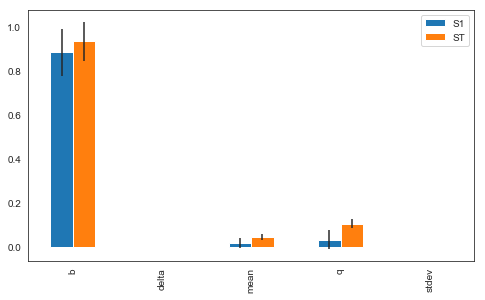

In [30]:
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

From the figure above we see that input variable 'b' has the highest total sensitivity index (ST). However, we also see that there is a slight difference between the first order sensitivity index (S1) with ST. The discrepancy between S1 and ST embodies the higher order sensitivity indices of the variable.

Another example for the utility outcome variable.

In [31]:
Si = sobol.analyze(problem, utility, calc_second_order=True)
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])
Si_df

,ST,ST_conf,S1,S1_conf
b,0.000000,0.000000,0.000000,0.000000
delta,0.993679,0.093631,0.991526,0.140267
mean,0.000000,0.000000,0.000000,0.000000
q,0.000000,0.000000,0.000000,0.000000
stdev,0.000000,0.000000,0.000000,0.000000


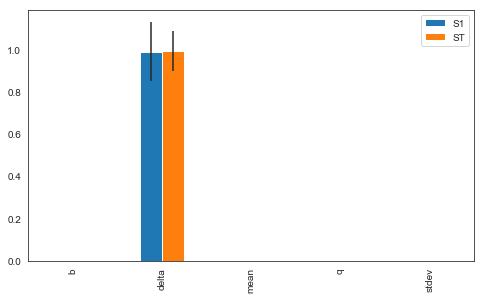

In [32]:
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()